# Conformational analysis of CXCL12

In this tutorial, we demonstrate how to use the HTMD code for doing conformational analysis.

To analyze, one needs MD trajectories first, which can be generated with HTMD. Here, we already provide the trajectories (data) to analyze. You can download the data from [here](http://pub.htmd.org/tutorials/cxcl12-conformational-analysis/filtered.tar.gz). (**Warning: 2.6 GB filesize**)

Alternatively, you can download the dataset using `wget`.

In [2]:
import os
assert os.system('wget -rcN -np -nH -q --cut-dirs=2 -R index.html* http://pub.htmd.org/tutorials/cxcl12-conformational-analysis/filtered/') == 0

## Getting started

First we import the modules we are going to need for the tutorial:

In [1]:
%pylab inline
from htmd.ui import *
config(viewer='webgl')

Populating the interactive namespace from numpy and matplotlib

Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. 
https://dx.doi.org/10.1021/acs.jctc.6b00049
Documentation: http://software.acellera.com/
To update: conda update htmd -c acellera -c psi4

You are on the latest HTMD version (unpackaged : /home/joao/maindisk/software/repos/Acellera/htmd/htmd).



## Introduction to CXCL12

CXCL12 is a chemokine involved in...

*  many types of cancer 
*  inflammatory diseases 
*  early development events

![system](http://pub.htmd.org/tutorials/cxcl12-conformational-analysis/system-protein2.png)

## Sampling major conformational states

There are many different metrics to assess the overall conformational changes of a protein. From them all, phi and psi angles of the protein backbone (dihedrals) have been the most successful descriptors in "blindly" capturing the major protein conformations.

In this section we will project our trajectories on the backbone dihedrals and, we will reduce the dimensionality by using tICA and then we will build a Markov Model to asses the major protein conformations in equilibrium.

![conformations](http://pub.htmd.org/tutorials/cxcl12-conformational-analysis/conformations.png)

## Load the trajectories into a simlist

In [2]:
fsims = simlist(glob('./filtered/*/'), './filtered/filtered.pdb')

Creating simlist: 100%|██████████| 289/289 [00:00<00:00, 2795.13it/s]


## Calculate metrics: protein backbone dihedrals

CXCL12 has a very flexible C-terminus loop as well as a transiently disorderable N-terminal alfa helix. In this study we are not interested in them but in the core of the chemokine. For this reason, we will select residues from 10 to 54. 

In [3]:
metr = Metric(fsims)
metr.set(MetricDihedral(protsel='protein and resid 10 to 54', sincos=True))
data = metr.project()
data.fstep = 0.1

Projecting trajectories:   0%|          | 1/289 [00:00<01:13,  3.89it/s]2018-03-20 02:12:04,241 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x4/1x4-GERARD_VERYLONG_CXCL12_confAna-0-1-RND4400_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:12:04,259 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x11/1x11-GERARD_VERYLONG_CXCL12_confAna-0-1-RND0220_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:12:04,271 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x3/1x3-GERARD_VERYLONG_CXCL12_confAna-0-1-RND2434_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:12:04,286 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x12/1x12-GERARD_VERYLONG_CXCL12_confAna-0-1-RND5012_9.filtered.xtc. Defaulting to 0.1ns framestep.
Projecting trajectories:  11%|█         | 32/289 [00:02<00:19, 13.05it/s]2018-03-20 02:12:06,279 - htmd.molecule.readers - WARNI

Projecting trajectories:  81%|████████  | 233/289 [00:16<00:03, 14.36it/s]2018-03-20 02:12:19,790 - htmd.molecule.readers - WARNING - No time information read from ./filtered/8x25/8x25-GERARD_VERYLONG_CXCL12_confAna-0-1-RND1273_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:12:19,809 - htmd.molecule.readers - WARNING - No time information read from ./filtered/8x27/8x27-GERARD_VERYLONG_CXCL12_confAna-0-1-RND6514_9.filtered.xtc. Defaulting to 0.1ns framestep.
Projecting trajectories:  91%|█████████ | 262/289 [00:17<00:01, 14.59it/s]2018-03-20 02:12:21,651 - htmd.molecule.readers - WARNING - No time information read from ./filtered/9x24/9x24-GERARD_VERYLONG_CXCL12_confAna-0-1-RND4916_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:12:21,697 - htmd.molecule.readers - WARNING - No time information read from ./filtered/9x29/9x29-GERARD_VERYLONG_CXCL12_confAna-0-1-RND3439_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:12:21,755 - htmd.molecule.readers 

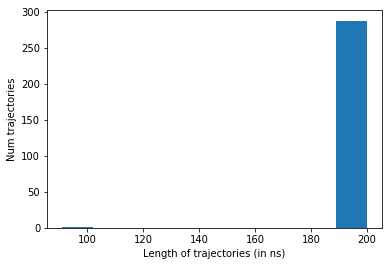

In [4]:
data.plotTrajSizes()

##  Dimensionality reduction

In [5]:
tica = TICA(data, 20)
dataTica = tica.project(3)

A Jupyter Widget

/home/joao/maindisk/SANDBOX/miniconda3/miniconda3/lib/python3.6/site-packages/pyemma/__init__.py:91: UserWarning: You are not using the latest release of PyEMMA. Latest is 2.5.1, you have 2.4.
  .format(latest=latest, current=current), category=UserWarning)


A Jupyter Widget

## Clustering

In [6]:
dataTica.cluster(MiniBatchKMeans(n_clusters=200), mergesmall=5)

2018-03-20 02:13:49,608 - htmd.metricdata - INFO - Mergesmall removed 0 clusters. Original ncluster 200, new ncluster 200.


## MSM analysis and visualization

A Jupyter Widget

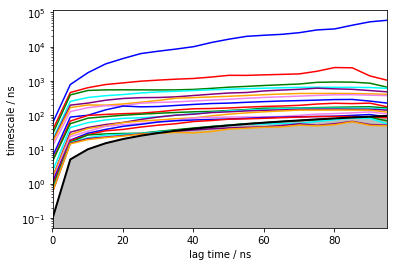

In [7]:
model = Model(dataTica)
model.plotTimescales(lags=list(range(1,1000,50)))

## Build Markov Model

2018-03-20 02:16:18,334 - htmd.model - INFO - 99.7% of the data was used
2018-03-20 02:16:18,373 - htmd.model - INFO - Number of trajectories that visited each macrostate:
2018-03-20 02:16:18,375 - htmd.model - INFO - [ 39 289  37   7   6  16  15 160]


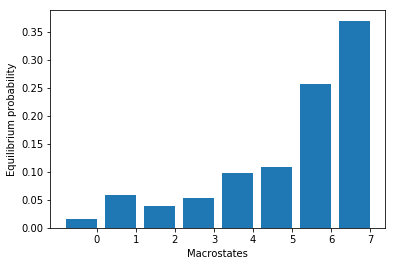

[ 0.01553383  0.0581622   0.03868523  0.05355839  0.0984875   0.1093136
  0.25694181  0.36931744]


In [8]:
model.markovModel(600, 8)
eqDist = model.eqDistribution()
print(eqDist)

We can now visualize representatives for each of the equilibrium species

In [9]:
model.numsamples=1
model.viewStates(protein=True)

Getting state Molecules:  38%|███▊      | 3/8 [00:03<00:06,  1.32s/it]2018-03-20 02:16:31,640 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x36/1x36-GERARD_VERYLONG_CXCL12_confAna-0-1-RND9406_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:16:31,644 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x36/1x36-GERARD_VERYLONG_CXCL12_confAna-0-1-RND9406_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:16:31,647 - htmd.molecule.readers - WARNING - No time information read from ./filtered/4x39/4x39-GERARD_VERYLONG_CXCL12_confAna-0-1-RND5184_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:16:31,651 - htmd.molecule.readers - WARNING - No time information read from ./filtered/5x10/5x10-GERARD_VERYLONG_CXCL12_confAna-0-1-RND2718_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:16:31,655 - htmd.molecule.readers - WARNING - No time information read from ./filtered/5x10/5x10-GERARD_VERYLONG

Getting state Molecules: 100%|██████████| 8/8 [00:13<00:00,  1.70s/it]


A Jupyter Widget

A Jupyter Widget

## Statistics: What are the major differences between the states X and Y?

,atomIndexes,description,type
22,"[253, 255, 262, 264]",Sine of angle of (SER 16 N A A) (SER 16 CA A A...,dihedral
23,"[253, 255, 262, 264]",Cosine of angle of (SER 16 N A A) (SER 16 CA A...,dihedral
28,"[262, 264, 266, 279]",Sine of angle of (SER 16 C A A) (HSD 17 N A A)...,dihedral
55,"[371, 373, 391, 393]",Cosine of angle of (LYS 24 N A A) (LYS 24 CA A...,dihedral
140,"[723, 725, 727, 737]",Sine of angle of (ASN 44 C A A) (ASN 45 N A A)...,dihedral


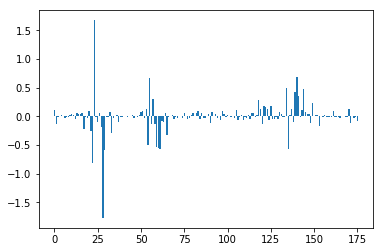

In [11]:
means = getStateStatistic(model, data, range(model.macronum))
plt.figure()
plt.bar(range(len(means[0])), means[7] - means[6])
idx = np.where(np.abs(means[7] - means[6]) > 0.6)[0]
data.map.ix[idx]

In [11]:
# we can visualize which residues are different between states
filtered = Molecule('./filtered/filtered.pdb')
filtered.view(sel='protein',style='NewCartoon',hold=True)
filtered.view(sel='resid 16 17 24 25 32 33 44 45',style='Licorice')

The installed widget Javascript is the wrong version.


## Mapping back: Which trajectory originated the state X?

In [12]:
np.where(model.macro_ofmicro == 6)

(array([ 40,  87, 115]),)

In [13]:
_,rel = model.sampleStates(10, 10, statetype='micro')
print(rel)

[array([[ 175, 1223],
       [ 201,  119],
       [ 155,  404],
       [   0, 1344],
       [ 215,  354],
       [  16,   15],
       [ 189,  197],
       [ 175, 1192],
       [ 177, 1406],
       [ 262,   33]])]


In [14]:
print(model.data.simlist[232])


simid = 232
parent = None
input = []
trajectory = ['./filtered/9x9/9x9-GERARD_VERYLONG_CXCL12_confAna-0-1-RND2283_9.filtered.xtc']
molfile = ./filtered/filtered.pdb
numframes = [2000]



## Studying a defined reaction coordinate

Revising the literature related to CXCL12, we find a paper published by Andrea Bernini et al. (2014), where they describe the opening of a pocket in CXCL12 located between the 2nd and 3rd beta sheet (see figure). To try to capture this phenomenon in our simulations, we will project our trajectories along the 2nd and 3rd beta-sheet distance.

![openclose_struc](http://pub.htmd.org/tutorials/cxcl12-conformational-analysis/openclose_struc.jpg)

_Figure extracted from Bernini et al., 2014, 1844(3):561-6. DOI:10.1016/j.bbapap.2013.12.012._

The first selection corresponds to beta-sheet 2 carbons alpha, the second one to beta-sheet 3 CA.
We specify `metric='contacts'` to create contact maps instead of proper distances. This means: create an interatom matrix and with 1's if the distance is below cutoff and 0's otherwise.

In [16]:
metr = Metric(fsims)
metr.set(MetricDistance('resid 38 to 42 and noh', 'resid 22 to 28 and noh', metric='contacts'))
data3 = metr.project()
data3.fstep = 0.1

Projecting trajectories:   0%|          | 1/289 [00:00<02:09,  2.22it/s]2018-03-20 02:20:30,897 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x3/1x3-GERARD_VERYLONG_CXCL12_confAna-0-1-RND2434_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:20:30,899 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x11/1x11-GERARD_VERYLONG_CXCL12_confAna-0-1-RND0220_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:20:30,889 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x4/1x4-GERARD_VERYLONG_CXCL12_confAna-0-1-RND4400_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:20:30,961 - htmd.molecule.readers - WARNING - No time information read from ./filtered/1x12/1x12-GERARD_VERYLONG_CXCL12_confAna-0-1-RND5012_9.filtered.xtc. Defaulting to 0.1ns framestep.
Projecting trajectories:  10%|█         | 30/289 [00:01<00:10, 24.47it/s]2018-03-20 02:20:31,494 - htmd.molecule.readers - WARNI

Projecting trajectories:  65%|██████▌   | 188/289 [00:10<00:05, 18.67it/s]2018-03-20 02:20:40,215 - htmd.molecule.readers - WARNING - No time information read from ./filtered/6x36/6x36-GERARD_VERYLONG_CXCL12_confAna-0-1-RND0862_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:20:40,306 - htmd.molecule.readers - WARNING - No time information read from ./filtered/6x39/6x39-GERARD_VERYLONG_CXCL12_confAna-0-1-RND6616_9.filtered.xtc. Defaulting to 0.1ns framestep.
Projecting trajectories:  70%|██████▉   | 201/289 [00:10<00:04, 18.35it/s]2018-03-20 02:20:40,937 - htmd.molecule.readers - WARNING - No time information read from ./filtered/7x21/7x21-GERARD_VERYLONG_CXCL12_confAna-0-1-RND1683_9.filtered.xtc. Defaulting to 0.1ns framestep.
2018-03-20 02:20:40,957 - htmd.molecule.readers - WARNING - No time information read from ./filtered/7x19/7x19-GERARD_VERYLONG_CXCL12_confAna-0-1-RND5246_9.filtered.xtc. Defaulting to 0.1ns framestep.
Projecting trajectories:  78%|███████▊  | 224/28

## tICA projection

Dimensionality reduction along the slow process

In [17]:
tica3 = TICA(data3, 20)
dataTica3 = tica3.project(3)

A Jupyter Widget

A Jupyter Widget

## Clustering

In [18]:
dataTica3.cluster(MiniBatchKMeans(n_clusters=200), mergesmall=5)

2018-03-20 02:29:10,507 - htmd.metricdata - INFO - Mergesmall removed 0 clusters. Original ncluster 200, new ncluster 200.


## Plot timescales

A Jupyter Widget

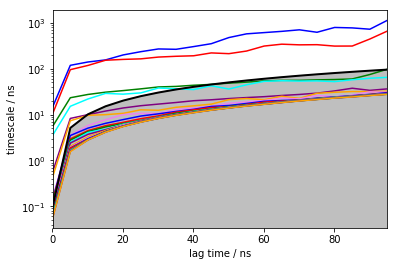

In [19]:
model3 = Model(dataTica3)
model3.plotTimescales(lags=list(range(1,1000,50)))

## Build a Markov Model

We want to pick a lagtime where the timescales are converged (timescale is flat). 600 is the lagtime we want to use (600 frames is equivalent to 60ns). 4 is the number of macrostates.

2018-03-20 02:29:38,610 - htmd.model - INFO - 100.0% of the data was used
2018-03-20 02:29:38,638 - htmd.model - INFO - Number of trajectories that visited each macrostate:
2018-03-20 02:29:38,640 - htmd.model - INFO - [  5   9  20 289]


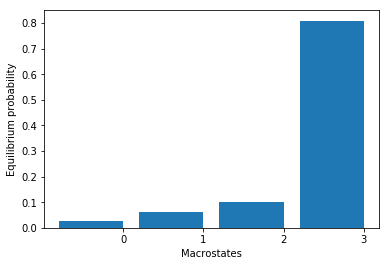

[ 0.02611681  0.06178354  0.10258197  0.80951768]


In [20]:
model3.markovModel(600, 4)
eqDist = model3.eqDistribution(plot=True)
print(eqDist)

## Visualize states

In [21]:
model3.viewStates(protein=True, numsamples=1)

Getting state Molecules: 100%|██████████| 4/4 [00:07<00:00,  1.83s/it]


A Jupyter Widget

A Jupyter Widget

## Analyse Open Conformation

Did you see any macrostate where the pocket is open? What is the equilibrium population probability? Let's try to find the trajectory that produced the state...

In [ ]:
# Map back the trajectory/ies that originated the macro. Substitute 1 for the macro that showed the pocket opening.
# This function is giving you the microclusters that are inside a given macrocluster

In [22]:
np.where(model3.macro_ofmicro ==1)

(array([ 5, 17]),)

In [23]:
# substitute 48 for the micro number from the previous step
# This function gives you trajectory-frame pairs that visited a given micro
_, rel = model3.sampleStates(48, 5, statetype='micro')
print(rel)

[array([[ 159,  622],
       [ 203,  622],
       [  79, 1356],
       [ 123, 1653],
       [ 151, 1222]])]


In [24]:
print(model3.data.simlist[277])


simid = 277
parent = None
input = []
trajectory = ['./filtered/10x23/10x23-GERARD_VERYLONG_CXCL12_confAna-0-1-RND9861_9.filtered.xtc']
molfile = ./filtered/filtered.pdb
numframes = [2000]



## Calculate RMSD of the site of interest for a selected trajectory

In [25]:
simus = simlist(glob('./filtered/10x23/'), './filtered/filtered.pdb')

Creating simlist: 100%|██████████| 1/1 [00:00<00:00, 523.83it/s]


In [26]:
refmol = Molecule('./filtered/filtered.pdb')
metr = Metric(simus)
metr.set(MetricRmsd(refmol, 'resid 38 to 42 or resid 22 to 28 and noh', trajalnstr='protein'))
rmsd = metr.project()

Projecting trajectories: 100%|██████████| 1/1 [00:00<00:00,  1.46it/s]
2018-03-20 02:30:34,130 - htmd.projections.metric - INFO - Frame step 0.10000000149011612ns was read from the trajectories. If it looks wrong, redefine it by manually setting the MetricData.fstep property.


## Do you see the pocket opening at 50ns?

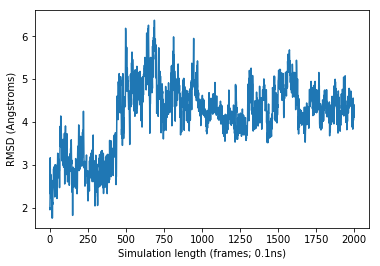

In [28]:
plt.plot(rmsd.dat[0])
plt.xlabel('Simulation length (frames; 0.1ns)', fontsize=10)
plt.ylabel('RMSD (Angstroms)', fontsize=10)
plt.show()

## Visualize the trajectory from your browser

In [29]:
refmol.read('./filtered/10x23/10x23-GERARD_VERYLONG_CXCL12_confAna-0-1-RND9861_9.filtered.xtc')
refmol.align('protein')
refmol.view()

A Jupyter Widget

This concludes the conformational analysis tutorial